# Probabilistic approach

In machine learning, we would like to build models that describe different real-world phenomena that we are interested in modeling. To build the model, we use data.

Without loss of generality, let us assume that we are interested in a classification problem.

## Different ways of learning from data

Let's play with the classical Iris problem: we want to predict the type of flower for a new given data point that describes a new flower. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scripts.utils import load_data

In [3]:
samples = load_data()
samples.describe()

,attr.a,attr.b,attr.c,attr.d,class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.806667,0.880000,0.853333,0.893333,1.000000
std,0.563982,0.432256,0.708403,0.743172,0.819232
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000


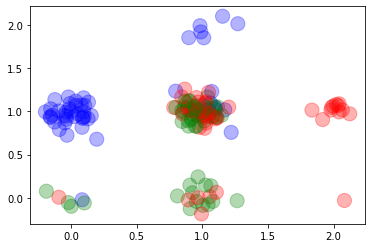

In [4]:
# Adding a bit of noise so that it's easier to visualize
data_with_noise = samples.iloc[:, :2] + np.random.normal(loc=0, scale=0.1, size=(150, 2))
plt.scatter(data_with_noise.iloc[:,0], data_with_noise.iloc[:,1], c=[ "bgr"[k] for k in samples.iloc[:,4] ], s=200, alpha=0.3)


<hr>

One possible way to learn from data is to try to find a function which directly maps an input vector to a class label. There are lots of algorithms for finding such a mapping function. For example, Decision Trees try to find a set of rules on individual attributes combined in a tree to classify data samples. 

Let's try to learn a Decision Tree from this dataset. 

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

desc_features=range(2) # we will use only two descriptive variables
class_feature=4
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(samples.iloc[:,desc_features], samples.iloc[:,class_feature])

accs=[]
for train_index, test_index in skf.split(samples.iloc[:,desc_features], samples.iloc[:,class_feature]):
    X_train, X_test = samples.iloc[train_index,desc_features], samples.iloc[test_index,desc_features]
    y_train, y_test = samples.iloc[train_index,class_feature], samples.iloc[test_index,class_feature]
    
    classifier = DecisionTreeClassifier(max_depth=4)
    classifier.fit(X_train, y_train)
    accs.append(classifier.score(X_test, y_test))
    
print("Mean accuracy:",np.mean(accs),"+-",np.std(accs))

Mean accuracy: 0.6866666666666666 +- 0.03399346342395189


## A probabilistic approach to machine learning

We could try to learn the joint probability distribution that models the relationship between all the variables, both descritive and the class. If we were able to infer this information, we could just perform basic probability operations (marginalization, reduction) given a new data point to get the probabilities of classes.

In [6]:
train_index = np.random.choice(150,size=120,replace=False)

Xy_train, Xy_test = samples.iloc[train_index,:], samples.loc[~samples.index.isin(train_index),:]

In [7]:
# Computing the joint probability distribution from the training data
joint_prob = Xy_train.groupby([*samples.columns[desc_features], 'class']).size() / 120
joint_prob

attr.a  attr.b  class
0       0       0        0.008333
                1        0.025000
                2        0.008333
        1       0        0.225000
1       0       1        0.083333
                2        0.025000
        1       0        0.058333
                1        0.250000
                2        0.225000
        2       0        0.041667
2       0       2        0.008333
        1       2        0.041667
dtype: float64

In [8]:
# Predicting values

# Selecting just the feature variables.
X_test = Xy_test.iloc[:, desc_features].values
y_test = Xy_test.iloc[:, class_feature].values

predicted_values = []
for i in X_test:
    predicted_values.append(joint_prob[i[0], i[1]].idxmax())
predicted_values = np.array(predicted_values)
score = (predicted_values == y_test).sum() / len(predicted_values)
print(score)

0.7333333333333333



In this example we saw how the probabilistic approach works. We construct the **joint probability distribution** over the variables of our problem given the data and then condition on the observed variables to compute the marginal distribution. And then we use these values to predict the probability of belonging to each class for new data points.

But the problem with this method is that the size of such a joint probability distribution is exponential to the number of possible values (cardinality) of the involved variables. Inference with this type of model quickly becomes unfeasible. 

<hr>

## Probabilistic Graphical Models

PGMs provide a way to compactly represent joint probability distributions over random variables by exploiting the (conditional) independencies between the variables. PGMs also provide methods for efficiently making inference over these distributions.

Each graphical model is characterized by a (directed or undirected) graph structure (that codifies the independencies) and a set of parameters.


### Types of Graphical Models

There are mainly 2 types of PGMs:
1. Bayesian Networks: BN consists of a directed graph and a Conditional Probability Distribution (CPD) associated with each node, $P(node | parents(node))$ [where $ parents(node) $ are the parents of the node in the graph structure].
2. Markov Networks: MNs consist of an undirected graph and are parameterized by Factors. Factors represent how much 2 or more variables agree with each other.